
### *Development Notebook*
# Extact flow across HEC-RAS Breaklines


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

### Enter HEC-RAS data info

In [2]:
# RAS Plan file (.hdf)
ras_data_file =  r'C:\Data\Breaklines\P01.p01.hdf'

# RAS domain (2d Flow area name)
RasDomain = 'P01'

# Enter cell-face pairs for dev/testing (cell -> face)
#cell -> face
cellFaceMap = {20387: 38073,
 20383: 38450,
 20389: 37862,
 20381: 38277,
 20377: 38653,
 20385: 38451}
# Auto-populated dictionaries
cellIDs = list(cellFaceMap.keys())
faceIDs = list(cellFaceMap.values())

#### Functions
Temporarily stored in cells during development. Move to `.py` for production

In [3]:
def hdfData(hdfFile:str, path:str):
    '''Get Data from HDF'''
    with h5py.File(hdfFile,'r') as hf:
        binary_data = np.array(hf[path])
        return binary_data 

def singlePlot(array):
    idx = np.arange(array.shape[0])
    fig, ax = plt.subplots(figsize=(12,3))
    ax.plot(idx, array);ax.grid()
    ax.set_title('Max {} \nMin {}'.format(str(array.max().round(4)), str(array.min().round(4))))
    return fig, ax


def mapTable(idxs, infoArray):
    '''From Info, get position of indexed data to build table'''
    table_map = {}
    for idx in idxs:
        start = infoArray[idx,0]
        stop = start + infoArray[idx,1]
        table_map[idx] = (start, stop)
    return table_map


def interp_areaEl(wsel, df):
    '''Interpolation function'''
    return np.interp(wsel,  df['Elevation'], df['Area'])


def extrapElevAreas(table_map, faceAreaElevations, faceNormalVectors,  extend_to=1000, plot=False):
    areaCurves = {}
    for face, idxs in table_map.items():
        
        fAEL_slice = faceAreaElevations[idxs[0]:idxs[1],[0,1]]
        faceVector = faceNormalVectors[face,2]
        maxElev = fAEL_slice[:, 0].max()
        maxArea = fAEL_slice[:, 1].max()
        
        # plot original curves
        if plot:
            fig, ax = plt.subplots(1,2, figsize=(20,3))
            ax[0].plot(fAEL_slice[:,1],fAEL_slice[:,0])
            ax[0].grid();ax[0].set_title(face);ax[0].set_xlabel('Area (sq ft)');ax[0].set_ylabel('WSE (ft)')
        
        # intialize data for extrapolation
        newElev = maxElev
        newArea = maxArea
        checkData=[]
        
        # extrapolate data
        for i in np.arange(1, extend_to, 1):
            newElev+=1
            newArea = maxArea + (i)*faceVector
            checkData.append([newElev, newArea])

        # append extrapolated rows to original table
        fAEL_slice = np.append(fAEL_slice, checkData, axis=0)
        

        # plot extrapolated curves
        if plot:
            ax[1].plot(fAEL_slice[:,1],fAEL_slice[:,0])
            ax[1].grid();ax[1].set_title(face);ax[1].set_xlabel('Area (extended, sq ft)');ax[1].set_ylabel('WSE (ft)')
            areaCurves[face] = fAEL_slice
        
    return areaCurves

#### Auto-populate RAS path variables

In [4]:
# Results
faceVel = '/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/{}/Face Velocity'.format(RasDomain)
cellWSE = '/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/{}/Water Surface'.format(RasDomain)

# Cell Geometry
cellFaceOrientInfo = '/Geometry/2D Flow Areas/{}/Cells Face and Orientation Info'.format(RasDomain)
cellFaceOrientVals = '/Geometry/2D Flow Areas/{}/Cells Face and Orientation Values'.format(RasDomain)
facePointOrientInfo = '/Geometry/2D Flow Areas/{}/FacePoints Face and Orientation Info'.format(RasDomain)
facePointOrientVals = '/Geometry/2D Flow Areas/{}/FacePoints Face and Orientation Values'.format(RasDomain)

# Face Geometry
faceInfo = '/Geometry/2D Flow Areas/{}/Faces Area Elevation Info'.format(RasDomain)
faceAreaEl= '/Geometry/2D Flow Areas/{}/Faces Area Elevation Values'.format(RasDomain)
faceCellIndex ='/Geometry/2D Flow Areas/{}/Faces Cell Indexes'.format(RasDomain)
faceNormalVector = '/Geometry/2D Flow Areas/{}/Faces NormalUnitVector and Length'.format(RasDomain)

### Read and plot WSEL's at each cells 

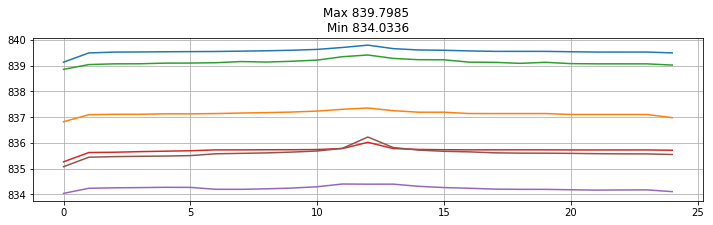

In [5]:
wses = hdfData(ras_data_file, cellWSE)
wse_slice = wses[:, cellIDs]
singlePlot(wse_slice);

#### Get Face Data
(Normal Unit Vector & Length)


```python
fNormal = {0 : 'Xcomp' 1 : 'Ycomp', 2 : 'Length'}
```

In [6]:
fNormal = hdfData(ras_data_file, faceNormalVector)
print('{} faces in hdf domain'.format(fNormal.shape[0]))

213702 faces in hdf domain


#### Plot Velocities at Faces corresponding to Cells

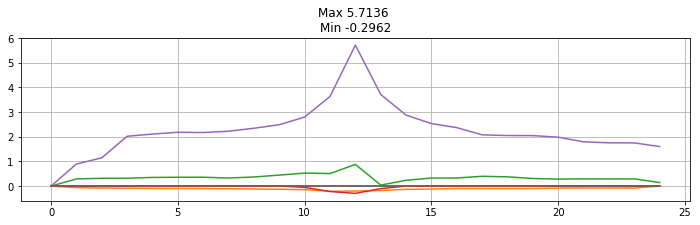

In [7]:
fVel = hdfData(ras_data_file, faceVel)
fVel_slice = fVel[:, faceIDs]
singlePlot(fVel_slice);

#### Get Rating Curve at each Cell Face for WSEL vs Area

(Area/elevation starting/ending positions)

```python

fInfo = {0:'Start', 1:'Length'}
    
```

In [8]:
# Read info to make area elevation curves at face
fInfo = hdfData(ras_data_file, faceInfo)
#fInfo

#### Create table to map Face Points with position in info vector
(Area/elevation)

```python

table_map = {'face' : fInfo['start'], fInfo['stop']}
    
```

In [9]:
table_map = mapTable(faceIDs, fInfo)
#table_map

#### Face Area Elevation map

```python

fAEL = {0:'Elevation', 1:'Area', 2: 'Wetted Perimeter', 3:'Mannings n}
    
```

In [10]:
# Read in complete table of area/elevation data
fAEl = hdfData(ras_data_file, faceAreaEl)
fAEl[:, [0,1]] # eleveation-area columns

array([[8.4844574e+02, 0.0000000e+00],
       [8.4864575e+02, 5.8933038e-01],
       [8.4879541e+02, 1.8011959e+00],
       ...,
       [7.0007520e+02, 2.4030344e+02],
       [7.0438245e+02, 3.8107880e+02],
       [7.0851239e+02, 7.8558417e+02]], dtype=float32)

#### Get Face Normal Vector Data

In [11]:
faceVectors = fNormal[faceIDs,2]
faceVectors

array([100., 100., 100., 100., 100., 100.], dtype=float32)

#### Read existing curve, extrapolate values, and plot


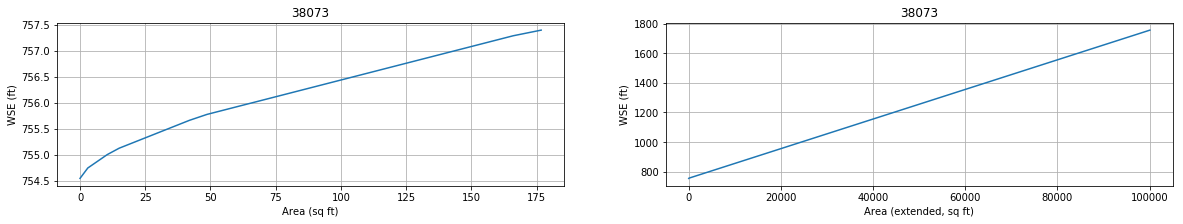

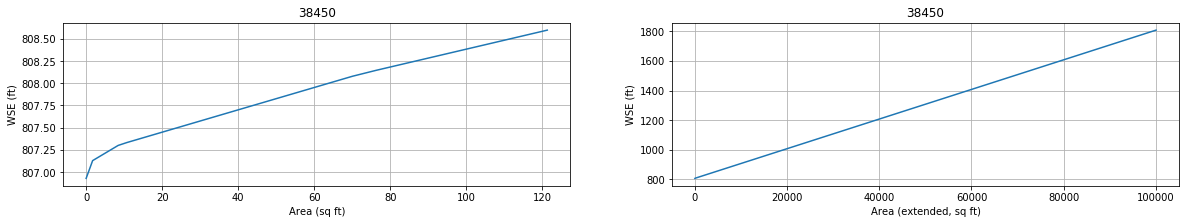

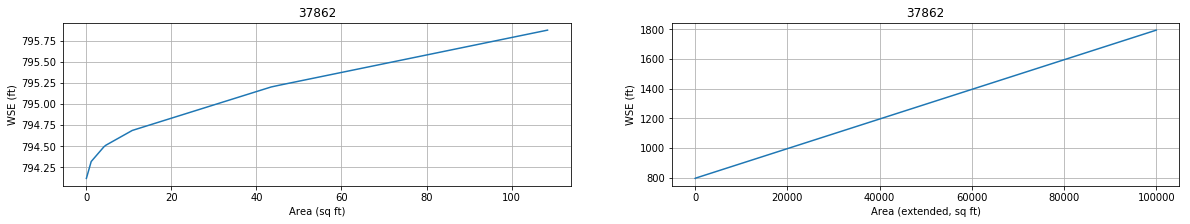

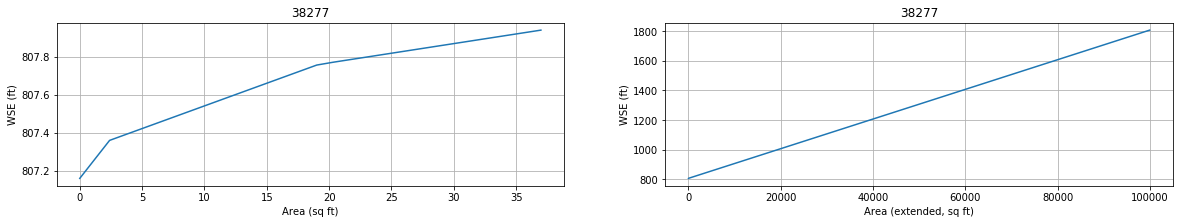

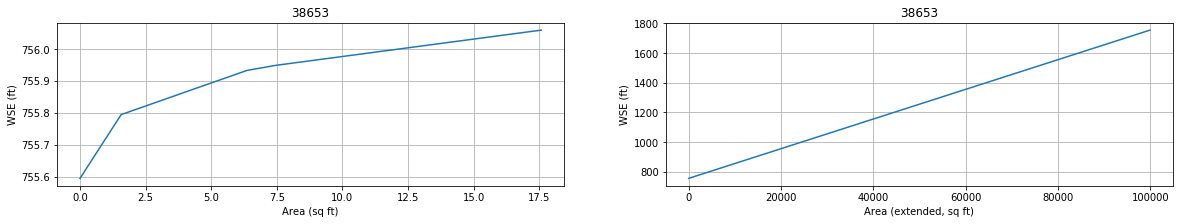

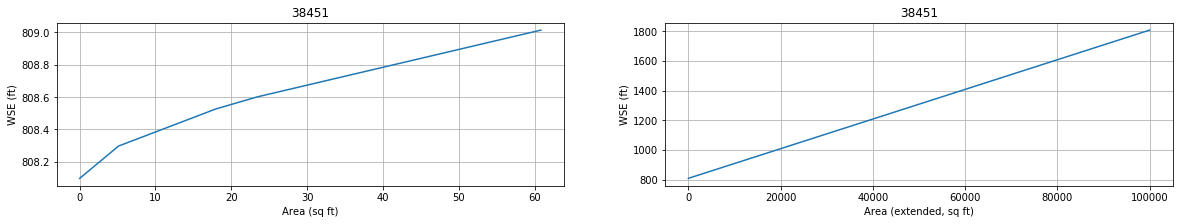

In [12]:
areaElevCurves = extrapElevAreas(table_map, fAEl, fNormal, plot=True)

### Compute and Plot flow at each cell/face pair

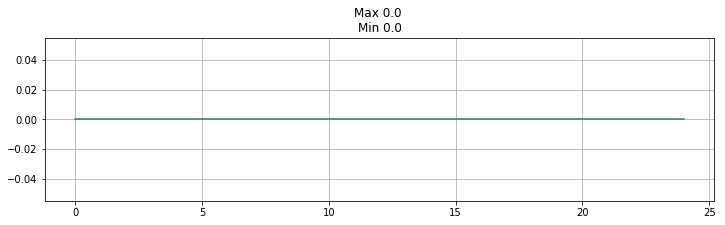

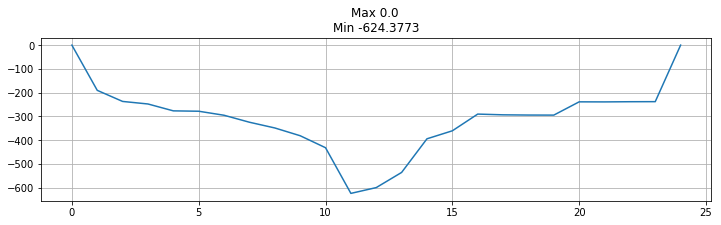

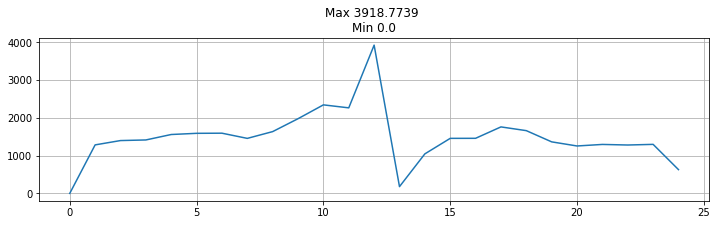

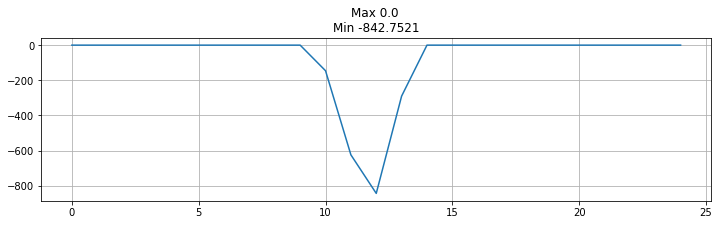

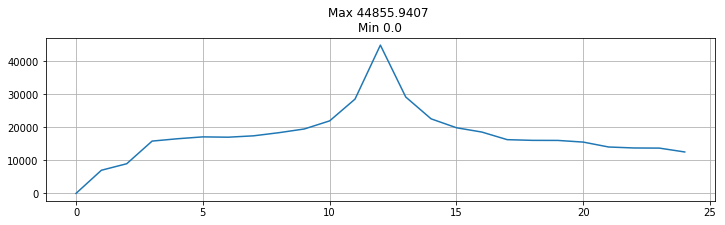

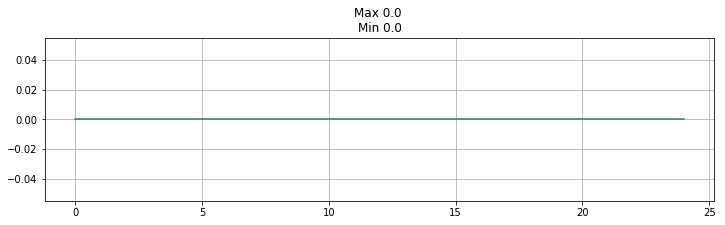

In [13]:
# Compute Flows at Cell/Face Pairs
for cell, face in cellFaceMap.items():
    wse_slice = wses[:, cell]
    faceArea = np.interp(wse_slice,  areaElevCurves[face][:,0], areaElevCurves[face][:,1])
    faceVelocity = fVel[:, face]
    faceFlow = faceVelocity*faceArea
    singlePlot(faceFlow);

### Plot total flow across breakline
*TODO*: remove `np.abs()` for flow calcs (current method for dev/testing, will often yield incorrect results)

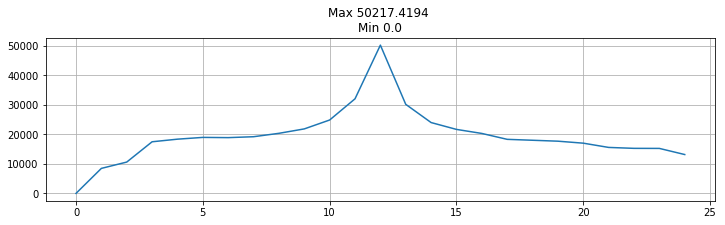

In [14]:
# Compute Flows at Cell/Face Pairs
breaklineFlow = np.zeros(wses[:, cellIDs[0]].shape)

for cell, face in cellFaceMap.items():
    wse_slice = wses[:, cell]
    faceArea = np.interp(wse_slice,  areaElevCurves[face][:,0], areaElevCurves[face][:,1])
    faceVelocity = fVel[:, face]
    faceFlow = faceVelocity*faceArea
    breaklineFlow+=np.abs(faceFlow)
    
singlePlot(breaklineFlow);

### Next Steps

 1. Add GIS data to auto-retrieve cell-face info from breaklines
 -  Use face vector info to adjust for velocity directionality